In [227]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb 12 17:51:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |  10331MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [228]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.71 s (started: 2022-02-12 17:51:59 +00:00)


In [229]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
time: 1.68 ms (started: 2022-02-12 17:52:02 +00:00)


In [230]:
!pip install --quiet optuna

time: 3.19 s (started: 2022-02-12 17:52:02 +00:00)


In [231]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
import keras 
from keras.utils.layer_utils import count_params


from xgboost import XGBClassifier

import optuna # hyeperparam optimization 

time: 18.1 ms (started: 2022-02-12 17:52:06 +00:00)


# Variables

## Paths

In [232]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220212_17H52/
time: 6.2 ms (started: 2022-02-12 17:52:06 +00:00)


## Other

In [233]:
# seed
random_seed = 42

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'


# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 5000  # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# retrain or load previously trained
retrain_model=True
# previously trained model dir 
model_dir = export_dir if retrain_model else "/content/"
# PREVIOUSLY TRAINED MODEL CHOOSE 7 or 2 epochs unfreeze  
trained_model_dir = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Hybrid DL+ML/Final DL model_2epochs unfreezed/'
trained_model_dir = '/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/Hybrid DL+ML/Final DL model_7epochs unfreezed/'
zip_trained_model_dir =  trained_model_dir + 'final_model.zip'

# epoch
epochs = 20
# epoch 2nd step:
n_epochs_2nd_step = 20 # 2 to stop just before overfit sur loss / 20 sinon pour laisser early stop faire le job 
# define base model  
model_name = 'EFB1'
base_model = tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False)
# feat extractor param 
# learing rate 
lr =9.972011089930672e-05 
# batch size 
batch_size = 16
# classifier architecture 
n_units_1, n_units_2 = 1024, 512
dropout_1, dropout_2 = 0.3 , 0.2 

# optuna & xgboostoptimiztion
tree_method = 'gpu_hist' if int(os.environ["COLAB_GPU"]) > 0 else 'hist'
n_trials = 50 # number optuna bayesian opt 
# XGBOSST inside objective 
n_estimators = 500 # nombre d'arbre xgboosting MAX qui sera limité par l'early stopping
early_stopping_rounds = 25  # window of the number of epochs over which no improvement is observed


# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 2.17 s (started: 2022-02-12 17:52:06 +00:00)


# Load & filter data

## Unzip images

In [234]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 3.19 ms (started: 2022-02-12 17:52:08 +00:00)


In [235]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 1.91 ms (started: 2022-02-12 17:52:08 +00:00)


## File_path df

In [236]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.



,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 1.66 s (started: 2022-02-12 17:52:08 +00:00)


In [237]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 2.47 ms (started: 2022-02-12 17:52:09 +00:00)


In [238]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 271 ms (started: 2022-02-12 17:52:09 +00:00)


In [239]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 153 ms (started: 2022-02-12 17:52:10 +00:00)


In [240]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 55 ms (started: 2022-02-12 17:52:10 +00:00)


In [241]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 44 ms (started: 2022-02-12 17:52:10 +00:00)


In [242]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 109 ms (started: 2022-02-12 17:52:10 +00:00)


In [243]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 18.8 ms (started: 2022-02-12 17:52:10 +00:00)


In [244]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 36.2 ms (started: 2022-02-12 17:52:10 +00:00)


In [245]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 67.1 ms (started: 2022-02-12 17:52:10 +00:00)


In [246]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 3.4 ms (started: 2022-02-12 17:52:10 +00:00)


In [247]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
44369,/content/RAW DATA/IMAGES/2010/Russula vinacea/...,Russulaceae,0
172598,/content/RAW DATA/IMAGES/2015/Lactarius delici...,Russulaceae,0
184582,/content/RAW DATA/IMAGES/2015/Tylopilus felleu...,Boletaceae,1
211179,/content/RAW DATA/IMAGES/2016/Russula parazure...,Russulaceae,0
63243,/content/RAW DATA/IMAGES/2011/Psilocybe cyanes...,Strophariaceae,2


time: 37.1 ms (started: 2022-02-12 17:52:10 +00:00)


In [248]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 1.58 ms (started: 2022-02-12 17:52:10 +00:00)


In [249]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 5000


,label,gbif_info.family,size
0,0,Russulaceae,855
1,1,Boletaceae,847
2,2,Strophariaceae,628
3,3,Tricholomataceae,694
4,4,Amanitaceae,666
5,5,Agaricaceae,734
6,6,Cortinariaceae,576


time: 17.5 ms (started: 2022-02-12 17:52:10 +00:00)


In [250]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Russulaceae',
 '1': 'Boletaceae',
 '2': 'Strophariaceae',
 '3': 'Tricholomataceae',
 '4': 'Amanitaceae',
 '5': 'Agaricaceae',
 '6': 'Cortinariaceae'}

time: 5.12 ms (started: 2022-02-12 17:52:10 +00:00)


## Train/test split

In [251]:
#train/test 
# Train/test
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
# train / val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
print(df_train_.shape,df_val_.shape,df_test.shape)

(3200, 3) (800, 3) (1000, 3)
time: 16.7 ms (started: 2022-02-12 17:52:10 +00:00)


In [252]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 5.38 ms (started: 2022-02-12 17:52:10 +00:00)


### Plot few images

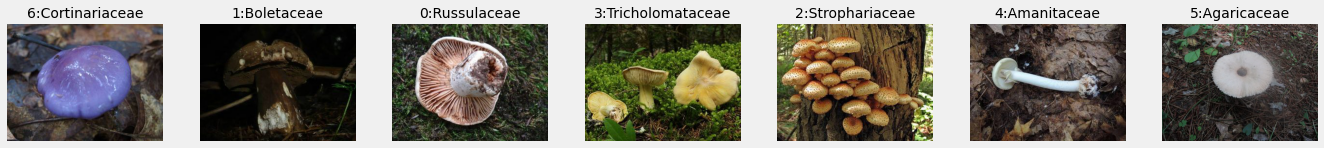

time: 401 ms (started: 2022-02-12 17:52:10 +00:00)


In [253]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

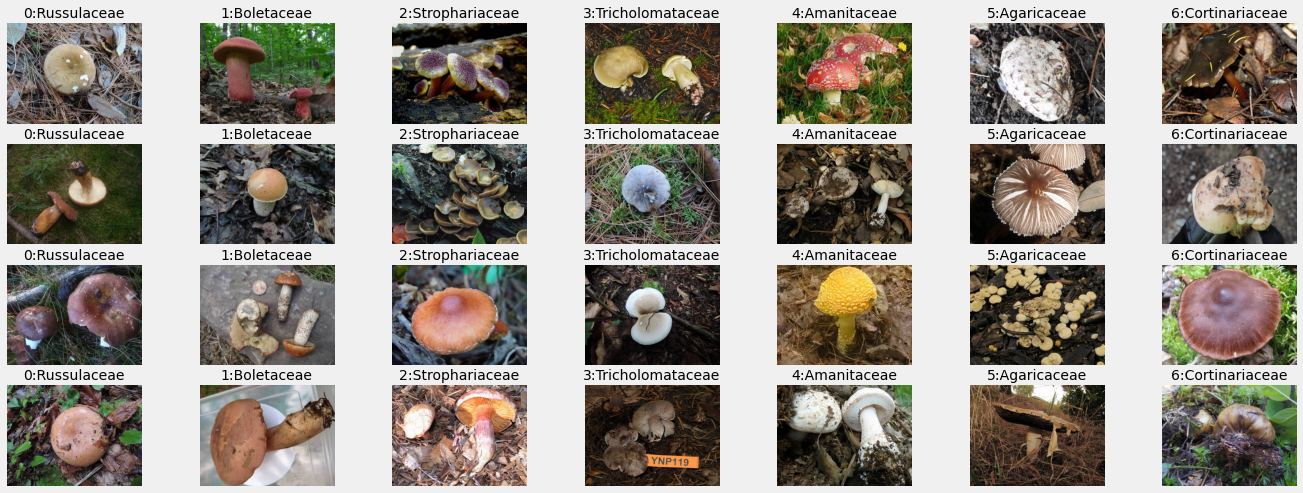

time: 1.41 s (started: 2022-02-12 17:52:11 +00:00)


In [254]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  try:
    col_number = family_number
    row_number = im_per_class
    ax = plt.subplot(row_number,col_number,j)
    im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
    plt.imshow(im)
    label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
    plt.title(label,size = 14)
    plt.axis('off')
  except:
    continue
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Callbacks & Fonctions

In [255]:
# pour catcher la convergence lors de la première phase 
early_stopping_step1 = EarlyStopping(
                                patience=2, # Attendre 2 epochs avant application
                                min_delta = 0.02, # si au bout de 2 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

early_stopping_step2 = EarlyStopping(
                                patience=3, # Attendre 5 epochs avant application
                                min_delta = 0.02, # si au bout de 4 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=2, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 5.89 ms (started: 2022-02-12 17:52:12 +00:00)


In [256]:
def plot_history(history,pathinfos):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history['loss'])), history['loss'], '-o', label = "training")
  plt.plot(range(len(history['val_loss'])), history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history['accuracy'])), history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history['val_accuracy'])), history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 11.5 ms (started: 2022-02-12 17:52:12 +00:00)


In [257]:
def plot_history_2steps(history,pathinfos,max_epoch_freeze=None):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))
  
  x = np.arange(1,(len(history['loss']))+1,1)
  plt.subplot(121)
  plt.plot(x, history['loss'], '-o', label = "training")
  plt.plot(x, history['val_loss'],  '-o',label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(x, history['accuracy'], '-o', label = "training")
  plt.plot(x, history['val_accuracy'], '-o', label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black' )
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 17.9 ms (started: 2022-02-12 17:52:12 +00:00)


In [258]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 24.3 ms (started: 2022-02-12 17:52:12 +00:00)


In [259]:
def conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(20,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')
  #add classif report 
  # plt.axvline(x=len(classes)+2, color = 'black')
  rep = metrics.classification_report(y_test_class, test_pred_class)
  plt.text(len(classes)+2.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+3, len(classes)-1, rep)
  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+11.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+12, (len(classes)+2)/2, lab_dict)



  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1.7,ha = 'center')


  # plt.show()
  plt.close()
  return fig

time: 38.3 ms (started: 2022-02-12 17:52:12 +00:00)


# Train feat extractor in two steps

In [260]:
# load model 
if not retrain_model:
  main_path = "/content/final_model"   
  if os.path.exists(main_path)== False :
    !unzip "$zip_trained_model_dir"  -d "/content"
  model = keras.models.load_model(model_dir +  'final_model')

time: 2.16 ms (started: 2022-02-12 17:52:12 +00:00)


## First step

In [261]:
# FUNCTIONNAL API  example 
# #load vgg16 without dense layer and with theano dim ordering
# base_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(resol[0], resol[1], 3))

# #number of classes in your dataset e.g. 20
# num_classes = 20

# x = keras.layers.Flatten()(base_model.output)
# x = keras.layers.Dense(4096, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.BatchNormalization()(x)
# predictions = Dense(num_classes, activation = 'softmax')(x)

# #create graph of your new model
# head_model = Model(inputs = base_model.input, outputs = predictions)

# #compile the model
# head_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# head_model.summary()

time: 1.89 ms (started: 2022-02-12 17:52:12 +00:00)


In [262]:
# functional API for transfer learning https://stackoverflow.com/questions/54727957/how-to-use-a-pretrained-keras-model-to-be-a-parameter-to-a-models-add-function
# base = base_model

# input = Input(shape=(150,225,3))
# base_out = base(input)
# out = Flatten()(base_out)
# model = Model(input, out)
# model.summary()

time: 890 µs (started: 2022-02-12 17:52:12 +00:00)


In [263]:
if retrain_model:
  # Clear clutter from previous TensorFlow graphs.
  tf.keras.backend.clear_session()
  # datagen 
  # train 
  train_data_generator_  = ImageDataGenerator(
                                            # rotation_range=0.1,horizontal_flip= True,vertical_flip= True
                                            ) 
  train_generator_ = train_data_generator_.flow_from_dataframe(dataframe = df_train_, 
                                                            x_col = "drive_file_path",y_col="label", 
                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')
  # val
  val_data_generator = ImageDataGenerator() 
  val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
                                                            x_col = "drive_file_path",y_col="label", 
                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')
  # FUNCTIONNAL API to get access to each layer after 
  #number of classes in your dataset e.g. 20
  x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  x = tf.keras.layers.Dense(units = n_units_1, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(dropout_1)(x)
  x = tf.keras.layers.Dense(units = n_units_2, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(dropout_2)(x)
  predictions = Dense(units = classes_count, activation = 'softmax')(x)
  #freeze/unfreeze all layers 
  for layer in base_model.layers:
      layer.trainable = False
  #create graph of your new model
  model = Model(inputs = base_model.input, outputs = predictions)
  model.summary()
  # export summary model & param 
  pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
  with open(export_dir + '_modelsummary.txt', 'w') as f:
      model.summary(print_fn=lambda x: f.write(x + '\n'))
  # compilation 
  optimizer =  'Adam'
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
  print('lr={}'.format(K.eval(model.optimizer.lr)))
  # Entraînement
  tic = time.time() # timer start
  training_history_model_1 = model.fit(train_generator_,epochs=epochs,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                    class_weight=class_weights,
                                  callbacks=[
                                            early_stopping_step1,
                                            reduce_learning_rate, 
                                              ],
                                  )
else: 
  model.summary()

Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 320, 3)  7           ['rescaling[0][0]']              
                                                                        

## Second step

**************************************************setting base model trainable**************************************************
trainable_count = 8291271 / non_trainable_count =  124103
lr=9.972011321224272e-05 / batch_size = 16
Epoch 5/24
200/200 [==============================] - 70s 302ms/step - loss: 1.0885 - accuracy: 0.6056 - val_loss: 1.0964 - val_accuracy: 0.5975 - lr: 9.9720e-05
Epoch 6/24
200/200 [==============================] - 59s 294ms/step - loss: 0.7385 - accuracy: 0.7400 - val_loss: 1.0937 - val_accuracy: 0.6187 - lr: 9.9720e-05
Epoch 7/24
200/200 [==============================] - 59s 294ms/step - loss: 0.4967 - accuracy: 0.8284 - val_loss: 1.0729 - val_accuracy: 0.6275 - lr: 9.9720e-05
Epoch 8/24
200/200 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.8872
Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.972011321224273e-06.
200/200 [==============================] - 59s 294ms/step - loss: 0.3198 - accuracy: 0.8872 - val_loss: 1.22

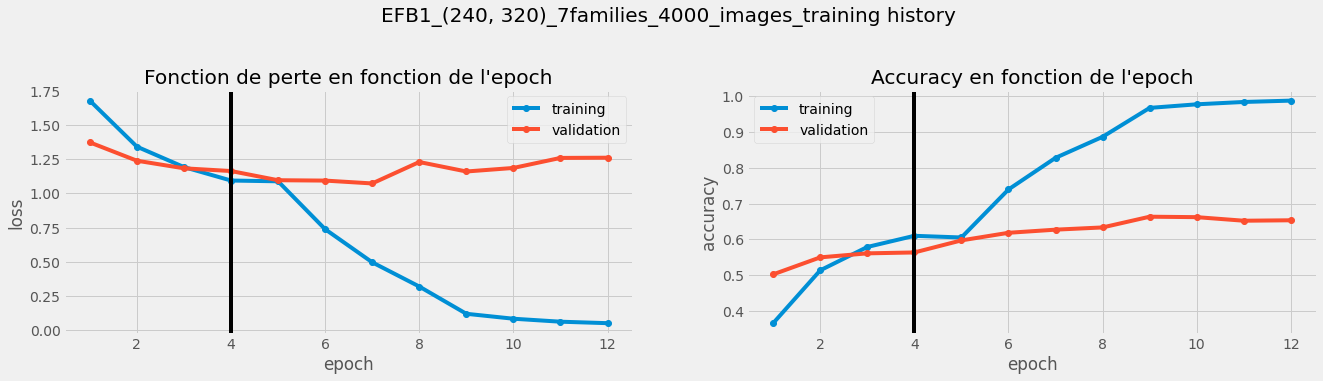

INFO:tensorflow:Assets written to: /content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220212_17H52/final_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



time: 8min 54s (started: 2022-02-12 17:53:23 +00:00)


In [264]:
if retrain_model: 
  #### FINE TUNING STEP cf https://www.tensorflow.org/guide/keras/transfer_learning
  print("*"*50 + 'setting base model trainable' + '*'*50)
  for layer in model.layers:
        layer.trainable = True  if not isinstance(layer, keras.layers.BatchNormalization) else False # batchnorm has to be freeze
  # check
  print('trainable_count = {} / non_trainable_count =  {}'.format(count_params(model.trainable_weights),count_params(model.non_trainable_weights)))
  # compile 2nd setp 
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  # get last lr 
  lr = training_history_model_1.history['lr'][-1] 
  K.set_value(model.optimizer.learning_rate, lr) 
  print('lr={} / batch_size = {}'.format(K.eval(model.optimizer.lr),batch_size))
  # define last epoch number to keep up
  max_epoch_freeze = len(training_history_model_1.history['accuracy'])
  # fine tuning 
  training_history_model_2 = model.fit(train_generator_,initial_epoch = max_epoch_freeze, # specify initial epoch 
                                  epochs=max_epoch_freeze + n_epochs_2nd_step,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                    class_weight=class_weights,
                                  callbacks=[
                                              early_stopping_step2,
                                              reduce_learning_rate
                                              ],
                                  )
  # timer end 
  tac = time.time()
  time_to_fit = tic - tac
  print('fite time = {}'.format(-round(time_to_fit/60,1)))
  # concat history 
  training_history_model = {}
  for (k1,v1),(k2,v2) in zip(training_history_model_1.history.items(),training_history_model_2.history.items()):
    training_history_model[k1] = v1 +v2 
  # Plot hIStory 
  training_history_fig = plot_history_2steps(training_history_model,pathinfos,max_epoch_freeze)
  display(training_history_fig)
  # save fig
  training_history_fig.savefig(export_dir +   '_training_history.jpeg',bbox_inches = 'tight' )
  # save model 
  model.save(export_dir  +  'final_model')
else:
  plt.figure(figsize=(20,10))
  im = io.imread(trained_model_dir + '_training_history.jpeg')
  plt.axis('off')
  plt.imshow(im)

## Test set results using DL only

In [265]:
# predict 
print("*"*50 + 'Predicting labels' + '*'*50)
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
y_prob = model.predict(test_generator,len(df_test)//batch_size)
test_pred_class= np.argmax(y_prob , axis=1)

**************************************************Predicting labels**************************************************
Found 1000 validated image filenames belonging to 7 classes.
time: 4.46 s (started: 2022-02-12 18:02:18 +00:00)


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       171
           1       0.81      0.80      0.81       169
           2       0.64      0.68      0.66       126
           3       0.55      0.60      0.58       139
           4       0.73      0.74      0.73       133
           5       0.63      0.60      0.62       147
           6       0.56      0.53      0.55       115

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



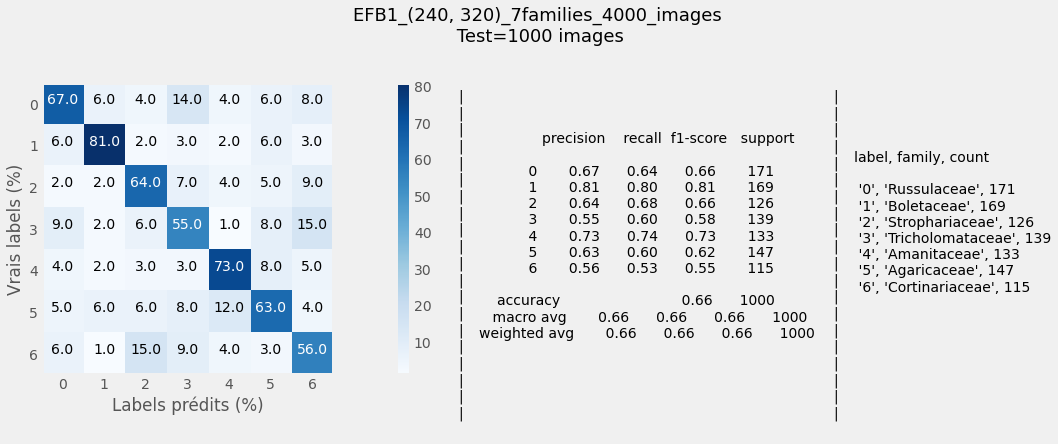

time: 766 ms (started: 2022-02-12 18:02:22 +00:00)


In [266]:
# true label
y_test_class= df_test['label'].values.astype(int)
print("*"*50 + 'TEST set classification report' + '*'*50)
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + '_classification report.csv'
report.to_csv(report_path)
# conf matrix 
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir +  'DL_model_conf_matrix.jpeg' ,bbox_inches = 'tight')

# Optuna

In [267]:
# on regenere un train et un valids genrators sans shuffle 
train_generator_ = train_data_generator_.flow_from_dataframe(dataframe = df_train_, 
                                                          x_col = "drive_file_path",y_col="label", 
                                                            shuffle = False,
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
                                                        shuffle = False,
                                                          x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')


Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
time: 43.1 ms (started: 2022-02-12 18:02:23 +00:00)


In [268]:
#get idx of layer with output (None,N) et pas autres tensor
flat_layers_idx = []
for idx in range(len(model.layers)-1): # on ne veut pas la dernière layer 
  if len(model.layers[idx].output_shape) == 2:
    print(idx, model.layers[idx].name,":",model.layers[idx].output_shape) 
    flat_layers_idx.append(idx)

10 block1a_se_squeeze : (None, 32)
20 block1b_se_squeeze : (None, 16)
36 block2a_se_squeeze : (None, 96)
49 block2b_se_squeeze : (None, 144)
64 block2c_se_squeeze : (None, 144)
80 block3a_se_squeeze : (None, 144)
93 block3b_se_squeeze : (None, 240)
108 block3c_se_squeeze : (None, 240)
124 block4a_se_squeeze : (None, 240)
137 block4b_se_squeeze : (None, 480)
152 block4c_se_squeeze : (None, 480)
167 block4d_se_squeeze : (None, 480)
182 block5a_se_squeeze : (None, 480)
195 block5b_se_squeeze : (None, 672)
210 block5c_se_squeeze : (None, 672)
225 block5d_se_squeeze : (None, 672)
241 block6a_se_squeeze : (None, 672)
254 block6b_se_squeeze : (None, 1152)
269 block6c_se_squeeze : (None, 1152)
284 block6d_se_squeeze : (None, 1152)
299 block6e_se_squeeze : (None, 1152)
314 block7a_se_squeeze : (None, 1152)
327 block7b_se_squeeze : (None, 1920)
339 global_average_pooling2d : (None, 1280)
340 dense : (None, 1024)
341 dropout : (None, 1024)
342 dense_1 : (None, 512)
343 dropout_1 : (None, 512)
tim

In [269]:
# /§\ cross val score donc df_train a la place de df_train_

time: 568 µs (started: 2022-02-12 18:02:23 +00:00)


In [271]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
def objective_SVC(trial):
  print('*'*50 + 'Trial' + str(trial.number) + '/' + str(n_trials) + ' started' + '*'*50)
  # define features extracted 
  # layer 1 pour global average layer (voir comment faire pour couches EFB1 :https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/ )
  # layer_number = int(trial.suggest_discrete_uniform('layer_number', 1, len(model.layers)-2,1))
  layer_number = int(trial.suggest_categorical('layer_number',flat_layers_idx)) 
  # layer_number = 2
  intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_number].output)
  X_train_features = intermediate_layer_model.predict(train_generator)
  print('X_train features shape: {}'.format(X_train_features.shape))
  # define target 
  y_train = df_train['label'] 

  # trial param  
  C= trial.suggest_loguniform("C", 0.001, 1000)
  text = 'trial ' + str(trial.number) + ':' + str(trial.params)
  print(text)
  print('DL model layer output = {}'.format(model.layers[layer_number].name))

  # ML model fit 
  svm = SVC(C=C)
  print('starting cross validation')
  skf = StratifiedKFold(n_splits=5)
  scores = cross_val_score(svm,X_train_features, y_train, cv=skf )
  print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
  
  return -scores.mean()  # a voir si on prend pas l'accuracy plus tard 

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
                            ) 
study.optimize(objective_SVC,n_trials=n_trials,callbacks= [lambda study, trial: gc.collect()])

[I 2022-02-12 18:04:11,673] A new study created in memory with name: no-name-8aa7963b-d00f-450c-a4d9-bfc4e205330e


**************************************************Trial0/50 started**************************************************
X_train features shape: (4000, 32)
trial 0:{'layer_number': 10, 'C': 0.005722026682703794}
DL model layer output = block1a_se_squeeze
starting cross validation


[I 2022-02-12 18:04:25,070] Trial 0 finished with value: -0.171 and parameters: {'layer_number': 10, 'C': 0.005722026682703794}. Best is trial 0 with value: -0.171.


0.17 accuracy with a standard deviation of 0.00
**************************************************Trial1/50 started**************************************************
X_train features shape: (4000, 240)
trial 1:{'layer_number': 108, 'C': 0.020232260765450556}
DL model layer output = block3c_se_squeeze
starting cross validation


[I 2022-02-12 18:04:47,449] Trial 1 finished with value: -0.171 and parameters: {'layer_number': 108, 'C': 0.020232260765450556}. Best is trial 0 with value: -0.171.


0.17 accuracy with a standard deviation of 0.00
**************************************************Trial2/50 started**************************************************
X_train features shape: (4000, 1024)
trial 2:{'layer_number': 340, 'C': 0.0059681949515941485}
DL model layer output = dense
starting cross validation


[I 2022-02-12 18:05:37,918] Trial 2 finished with value: -0.26375000000000004 and parameters: {'layer_number': 340, 'C': 0.0059681949515941485}. Best is trial 2 with value: -0.26375000000000004.


0.26 accuracy with a standard deviation of 0.00
**************************************************Trial3/50 started**************************************************
X_train features shape: (4000, 1152)
trial 3:{'layer_number': 314, 'C': 0.2266016323589887}
DL model layer output = block7a_se_squeeze
starting cross validation


[I 2022-02-12 18:06:22,238] Trial 3 finished with value: -0.75425 and parameters: {'layer_number': 314, 'C': 0.2266016323589887}. Best is trial 3 with value: -0.75425.


0.75 accuracy with a standard deviation of 0.02
**************************************************Trial4/50 started**************************************************
X_train features shape: (4000, 480)
trial 4:{'layer_number': 182, 'C': 6.755962394267811}
DL model layer output = block5a_se_squeeze
starting cross validation


[I 2022-02-12 18:06:49,492] Trial 4 finished with value: -0.46399999999999997 and parameters: {'layer_number': 182, 'C': 6.755962394267811}. Best is trial 3 with value: -0.75425.


0.46 accuracy with a standard deviation of 0.01
**************************************************Trial5/50 started**************************************************
X_train features shape: (4000, 672)
trial 5:{'layer_number': 195, 'C': 0.11943814348966289}
DL model layer output = block5b_se_squeeze
starting cross validation


[I 2022-02-12 18:07:26,300] Trial 5 finished with value: -0.309 and parameters: {'layer_number': 195, 'C': 0.11943814348966289}. Best is trial 3 with value: -0.75425.


0.31 accuracy with a standard deviation of 0.01
**************************************************Trial6/50 started**************************************************
X_train features shape: (4000, 1280)
trial 6:{'layer_number': 339, 'C': 0.5381819848502222}
DL model layer output = global_average_pooling2d
starting cross validation


[I 2022-02-12 18:08:04,596] Trial 6 finished with value: -0.9155000000000001 and parameters: {'layer_number': 339, 'C': 0.5381819848502222}. Best is trial 6 with value: -0.9155000000000001.


0.92 accuracy with a standard deviation of 0.01
**************************************************Trial7/50 started**************************************************
X_train features shape: (4000, 672)
trial 7:{'layer_number': 195, 'C': 14.459067906110345}
DL model layer output = block5b_se_squeeze
starting cross validation


[I 2022-02-12 18:08:41,793] Trial 7 finished with value: -0.48525 and parameters: {'layer_number': 195, 'C': 14.459067906110345}. Best is trial 6 with value: -0.9155000000000001.


0.49 accuracy with a standard deviation of 0.02
**************************************************Trial8/50 started**************************************************
X_train features shape: (4000, 480)
trial 8:{'layer_number': 137, 'C': 0.09593150225905306}
DL model layer output = block4b_se_squeeze
starting cross validation


[I 2022-02-12 18:09:12,735] Trial 8 finished with value: -0.21550000000000002 and parameters: {'layer_number': 137, 'C': 0.09593150225905306}. Best is trial 6 with value: -0.9155000000000001.


0.22 accuracy with a standard deviation of 0.01
**************************************************Trial9/50 started**************************************************
X_train features shape: (4000, 96)
trial 9:{'layer_number': 36, 'C': 0.0549109975499735}
DL model layer output = block2a_se_squeeze
starting cross validation


[I 2022-02-12 18:09:29,798] Trial 9 finished with value: -0.1715 and parameters: {'layer_number': 36, 'C': 0.0549109975499735}. Best is trial 6 with value: -0.9155000000000001.


0.17 accuracy with a standard deviation of 0.00
**************************************************Trial10/50 started**************************************************
X_train features shape: (4000, 1280)
trial 10:{'layer_number': 339, 'C': 399.2521198852569}
DL model layer output = global_average_pooling2d
starting cross validation


[I 2022-02-12 18:10:08,197] Trial 10 finished with value: -0.9182500000000001 and parameters: {'layer_number': 339, 'C': 399.2521198852569}. Best is trial 10 with value: -0.9182500000000001.


0.92 accuracy with a standard deviation of 0.01
**************************************************Trial11/50 started**************************************************
X_train features shape: (4000, 1280)
trial 11:{'layer_number': 339, 'C': 517.290708659078}
DL model layer output = global_average_pooling2d
starting cross validation


[I 2022-02-12 18:10:46,801] Trial 11 finished with value: -0.9182500000000001 and parameters: {'layer_number': 339, 'C': 517.290708659078}. Best is trial 10 with value: -0.9182500000000001.


0.92 accuracy with a standard deviation of 0.01
**************************************************Trial12/50 started**************************************************
X_train features shape: (4000, 672)
trial 12:{'layer_number': 210, 'C': 947.5227857752844}
DL model layer output = block5c_se_squeeze
starting cross validation


[I 2022-02-12 18:11:24,371] Trial 12 finished with value: -0.50675 and parameters: {'layer_number': 210, 'C': 947.5227857752844}. Best is trial 10 with value: -0.9182500000000001.


0.51 accuracy with a standard deviation of 0.01
**************************************************Trial13/50 started**************************************************
X_train features shape: (4000, 1280)
trial 13:{'layer_number': 339, 'C': 977.2883383092791}
DL model layer output = global_average_pooling2d
starting cross validation


[I 2022-02-12 18:12:02,771] Trial 13 finished with value: -0.9182500000000001 and parameters: {'layer_number': 339, 'C': 977.2883383092791}. Best is trial 10 with value: -0.9182500000000001.


0.92 accuracy with a standard deviation of 0.01
**************************************************Trial14/50 started**************************************************
X_train features shape: (4000, 1280)
trial 14:{'layer_number': 339, 'C': 69.57726173984867}
DL model layer output = global_average_pooling2d
starting cross validation


[I 2022-02-12 18:12:41,216] Trial 14 finished with value: -0.9182500000000001 and parameters: {'layer_number': 339, 'C': 69.57726173984867}. Best is trial 10 with value: -0.9182500000000001.


0.92 accuracy with a standard deviation of 0.01
**************************************************Trial15/50 started**************************************************
X_train features shape: (4000, 480)
trial 15:{'layer_number': 152, 'C': 88.39101874627889}
DL model layer output = block4c_se_squeeze
starting cross validation


[I 2022-02-12 18:13:14,908] Trial 15 finished with value: -0.4065 and parameters: {'layer_number': 152, 'C': 88.39101874627889}. Best is trial 10 with value: -0.9182500000000001.


0.41 accuracy with a standard deviation of 0.01
**************************************************Trial16/50 started**************************************************
X_train features shape: (4000, 1024)
trial 16:{'layer_number': 341, 'C': 130.33533570011176}
DL model layer output = dropout
starting cross validation


[I 2022-02-12 18:13:39,653] Trial 16 finished with value: -0.93 and parameters: {'layer_number': 341, 'C': 130.33533570011176}. Best is trial 16 with value: -0.93.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial17/50 started**************************************************
X_train features shape: (4000, 1024)
trial 17:{'layer_number': 341, 'C': 4.098768658136003}
DL model layer output = dropout
starting cross validation


[I 2022-02-12 18:14:04,197] Trial 17 finished with value: -0.9297500000000001 and parameters: {'layer_number': 341, 'C': 4.098768658136003}. Best is trial 16 with value: -0.93.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial18/50 started**************************************************
X_train features shape: (4000, 1024)
trial 18:{'layer_number': 341, 'C': 3.913365402523478}
DL model layer output = dropout
starting cross validation


[I 2022-02-12 18:14:28,690] Trial 18 finished with value: -0.93 and parameters: {'layer_number': 341, 'C': 3.913365402523478}. Best is trial 16 with value: -0.93.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial19/50 started**************************************************
X_train features shape: (4000, 1024)
trial 19:{'layer_number': 341, 'C': 2.187930431672876}
DL model layer output = dropout
starting cross validation


[I 2022-02-12 18:14:52,895] Trial 19 finished with value: -0.9307500000000001 and parameters: {'layer_number': 341, 'C': 2.187930431672876}. Best is trial 19 with value: -0.9307500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial20/50 started**************************************************
X_train features shape: (4000, 1024)
trial 20:{'layer_number': 341, 'C': 1.7605475724642763}
DL model layer output = dropout
starting cross validation


[I 2022-02-12 18:15:16,944] Trial 20 finished with value: -0.93025 and parameters: {'layer_number': 341, 'C': 1.7605475724642763}. Best is trial 19 with value: -0.9307500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial21/50 started**************************************************
X_train features shape: (4000, 1024)
trial 21:{'layer_number': 341, 'C': 1.6480809616149181}
DL model layer output = dropout
starting cross validation


[I 2022-02-12 18:15:41,011] Trial 21 finished with value: -0.93 and parameters: {'layer_number': 341, 'C': 1.6480809616149181}. Best is trial 19 with value: -0.9307500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial22/50 started**************************************************
X_train features shape: (4000, 1024)
trial 22:{'layer_number': 341, 'C': 1.047106288005828}
DL model layer output = dropout
starting cross validation


[I 2022-02-12 18:16:05,071] Trial 22 finished with value: -0.93025 and parameters: {'layer_number': 341, 'C': 1.047106288005828}. Best is trial 19 with value: -0.9307500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial23/50 started**************************************************
X_train features shape: (4000, 240)
trial 23:{'layer_number': 93, 'C': 0.7738006527590675}
DL model layer output = block3b_se_squeeze
starting cross validation


[I 2022-02-12 18:16:26,902] Trial 23 finished with value: -0.28700000000000003 and parameters: {'layer_number': 93, 'C': 0.7738006527590675}. Best is trial 19 with value: -0.9307500000000001.


0.29 accuracy with a standard deviation of 0.02
**************************************************Trial24/50 started**************************************************
X_train features shape: (4000, 672)
trial 24:{'layer_number': 225, 'C': 26.9829088572779}
DL model layer output = block5d_se_squeeze
starting cross validation


[I 2022-02-12 18:17:03,987] Trial 24 finished with value: -0.53725 and parameters: {'layer_number': 225, 'C': 26.9829088572779}. Best is trial 19 with value: -0.9307500000000001.


0.54 accuracy with a standard deviation of 0.02
**************************************************Trial25/50 started**************************************************
X_train features shape: (4000, 1920)
trial 25:{'layer_number': 327, 'C': 1.474803222744079}
DL model layer output = block7b_se_squeeze
starting cross validation


[I 2022-02-12 18:17:59,251] Trial 25 finished with value: -0.8627500000000001 and parameters: {'layer_number': 327, 'C': 1.474803222744079}. Best is trial 19 with value: -0.9307500000000001.


0.86 accuracy with a standard deviation of 0.01
**************************************************Trial26/50 started**************************************************
X_train features shape: (4000, 512)
trial 26:{'layer_number': 343, 'C': 0.3687374328017485}
DL model layer output = dropout_1
starting cross validation


[I 2022-02-12 18:18:15,987] Trial 26 finished with value: -0.9317500000000001 and parameters: {'layer_number': 343, 'C': 0.3687374328017485}. Best is trial 26 with value: -0.9317500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial27/50 started**************************************************
X_train features shape: (4000, 1152)
trial 27:{'layer_number': 284, 'C': 0.43885545396012365}
DL model layer output = block6d_se_squeeze
starting cross validation


[I 2022-02-12 18:19:01,787] Trial 27 finished with value: -0.63925 and parameters: {'layer_number': 284, 'C': 0.43885545396012365}. Best is trial 26 with value: -0.9317500000000001.


0.64 accuracy with a standard deviation of 0.01
**************************************************Trial28/50 started**************************************************
X_train features shape: (4000, 512)
trial 28:{'layer_number': 343, 'C': 0.001116599624763457}
DL model layer output = dropout_1
starting cross validation


[I 2022-02-12 18:19:35,070] Trial 28 finished with value: -0.171 and parameters: {'layer_number': 343, 'C': 0.001116599624763457}. Best is trial 26 with value: -0.9317500000000001.


0.17 accuracy with a standard deviation of 0.00
**************************************************Trial29/50 started**************************************************
X_train features shape: (4000, 144)
trial 29:{'layer_number': 80, 'C': 0.018705234212407308}
DL model layer output = block3a_se_squeeze
starting cross validation


[I 2022-02-12 18:19:54,349] Trial 29 finished with value: -0.171 and parameters: {'layer_number': 80, 'C': 0.018705234212407308}. Best is trial 26 with value: -0.9317500000000001.


0.17 accuracy with a standard deviation of 0.00
**************************************************Trial30/50 started**************************************************
X_train features shape: (4000, 480)
trial 30:{'layer_number': 167, 'C': 0.25822468231135237}
DL model layer output = block4d_se_squeeze
starting cross validation


[I 2022-02-12 18:20:24,442] Trial 30 finished with value: -0.30925 and parameters: {'layer_number': 167, 'C': 0.25822468231135237}. Best is trial 26 with value: -0.9317500000000001.


0.31 accuracy with a standard deviation of 0.01
**************************************************Trial31/50 started**************************************************
X_train features shape: (4000, 144)
trial 31:{'layer_number': 64, 'C': 2.077699575787537}
DL model layer output = block2c_se_squeeze
starting cross validation


[I 2022-02-12 18:20:43,208] Trial 31 finished with value: -0.26875 and parameters: {'layer_number': 64, 'C': 2.077699575787537}. Best is trial 26 with value: -0.9317500000000001.


0.27 accuracy with a standard deviation of 0.02
**************************************************Trial32/50 started**************************************************
X_train features shape: (4000, 672)
trial 32:{'layer_number': 241, 'C': 11.177214337755046}
DL model layer output = block6a_se_squeeze
starting cross validation


[I 2022-02-12 18:21:11,501] Trial 32 finished with value: -0.595 and parameters: {'layer_number': 241, 'C': 11.177214337755046}. Best is trial 26 with value: -0.9317500000000001.


0.59 accuracy with a standard deviation of 0.02
**************************************************Trial33/50 started**************************************************
X_train features shape: (4000, 16)
trial 33:{'layer_number': 20, 'C': 0.9637741542394729}
DL model layer output = block1b_se_squeeze
starting cross validation


[I 2022-02-12 18:21:25,761] Trial 33 finished with value: -0.171 and parameters: {'layer_number': 20, 'C': 0.9637741542394729}. Best is trial 26 with value: -0.9317500000000001.


0.17 accuracy with a standard deviation of 0.00
**************************************************Trial34/50 started**************************************************
X_train features shape: (4000, 240)
trial 34:{'layer_number': 124, 'C': 3.4620837891905314}
DL model layer output = block4a_se_squeeze
starting cross validation


[I 2022-02-12 18:21:47,578] Trial 34 finished with value: -0.32225000000000004 and parameters: {'layer_number': 124, 'C': 3.4620837891905314}. Best is trial 26 with value: -0.9317500000000001.


0.32 accuracy with a standard deviation of 0.01
**************************************************Trial35/50 started**************************************************
X_train features shape: (4000, 144)
trial 35:{'layer_number': 49, 'C': 0.3170643667535819}
DL model layer output = block2b_se_squeeze
starting cross validation


[I 2022-02-12 18:22:06,662] Trial 35 finished with value: -0.20925 and parameters: {'layer_number': 49, 'C': 0.3170643667535819}. Best is trial 26 with value: -0.9317500000000001.


0.21 accuracy with a standard deviation of 0.00
**************************************************Trial36/50 started**************************************************
X_train features shape: (4000, 512)
trial 36:{'layer_number': 342, 'C': 0.05364443598629966}
DL model layer output = dense_1
starting cross validation


[I 2022-02-12 18:22:27,337] Trial 36 finished with value: -0.9315000000000001 and parameters: {'layer_number': 342, 'C': 0.05364443598629966}. Best is trial 26 with value: -0.9317500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial37/50 started**************************************************
X_train features shape: (4000, 512)
trial 37:{'layer_number': 342, 'C': 0.022970456563050152}
DL model layer output = dense_1
starting cross validation


[I 2022-02-12 18:22:52,045] Trial 37 finished with value: -0.9305 and parameters: {'layer_number': 342, 'C': 0.022970456563050152}. Best is trial 26 with value: -0.9317500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial38/50 started**************************************************
X_train features shape: (4000, 512)
trial 38:{'layer_number': 342, 'C': 0.020392491917631487}
DL model layer output = dense_1
starting cross validation


[I 2022-02-12 18:23:17,205] Trial 38 finished with value: -0.9295000000000002 and parameters: {'layer_number': 342, 'C': 0.020392491917631487}. Best is trial 26 with value: -0.9317500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial39/50 started**************************************************
X_train features shape: (4000, 512)
trial 39:{'layer_number': 342, 'C': 0.005808794538556347}
DL model layer output = dense_1
starting cross validation


[I 2022-02-12 18:23:50,041] Trial 39 finished with value: -0.759 and parameters: {'layer_number': 342, 'C': 0.005808794538556347}. Best is trial 26 with value: -0.9317500000000001.


0.76 accuracy with a standard deviation of 0.00
**************************************************Trial40/50 started**************************************************
X_train features shape: (4000, 1152)
trial 40:{'layer_number': 299, 'C': 0.039659583647499594}
DL model layer output = block6e_se_squeeze
starting cross validation


[I 2022-02-12 18:24:44,828] Trial 40 finished with value: -0.321 and parameters: {'layer_number': 299, 'C': 0.039659583647499594}. Best is trial 26 with value: -0.9317500000000001.


0.32 accuracy with a standard deviation of 0.01
**************************************************Trial41/50 started**************************************************
X_train features shape: (4000, 1152)
trial 41:{'layer_number': 269, 'C': 0.12352363073285838}
DL model layer output = block6c_se_squeeze
starting cross validation


[I 2022-02-12 18:25:38,012] Trial 41 finished with value: -0.49349999999999994 and parameters: {'layer_number': 269, 'C': 0.12352363073285838}. Best is trial 26 with value: -0.9317500000000001.


0.49 accuracy with a standard deviation of 0.01
**************************************************Trial42/50 started**************************************************
X_train features shape: (4000, 1152)
trial 42:{'layer_number': 254, 'C': 0.0024221584931955814}
DL model layer output = block6b_se_squeeze
starting cross validation


[I 2022-02-12 18:26:32,947] Trial 42 finished with value: -0.171 and parameters: {'layer_number': 254, 'C': 0.0024221584931955814}. Best is trial 26 with value: -0.9317500000000001.


0.17 accuracy with a standard deviation of 0.00
**************************************************Trial43/50 started**************************************************
X_train features shape: (4000, 32)
trial 43:{'layer_number': 10, 'C': 0.009976356575820123}
DL model layer output = block1a_se_squeeze
starting cross validation


[I 2022-02-12 18:26:47,273] Trial 43 finished with value: -0.171 and parameters: {'layer_number': 10, 'C': 0.009976356575820123}. Best is trial 26 with value: -0.9317500000000001.


0.17 accuracy with a standard deviation of 0.00
**************************************************Trial44/50 started**************************************************
X_train features shape: (4000, 240)
trial 44:{'layer_number': 108, 'C': 0.14524908195141079}
DL model layer output = block3c_se_squeeze
starting cross validation


[I 2022-02-12 18:27:09,968] Trial 44 finished with value: -0.22600000000000003 and parameters: {'layer_number': 108, 'C': 0.14524908195141079}. Best is trial 26 with value: -0.9317500000000001.


0.23 accuracy with a standard deviation of 0.01
**************************************************Trial45/50 started**************************************************
X_train features shape: (4000, 512)
trial 45:{'layer_number': 343, 'C': 0.051270682957040854}
DL model layer output = dropout_1
starting cross validation


[I 2022-02-12 18:27:30,815] Trial 45 finished with value: -0.9315000000000001 and parameters: {'layer_number': 343, 'C': 0.051270682957040854}. Best is trial 26 with value: -0.9317500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial46/50 started**************************************************
X_train features shape: (4000, 512)
trial 46:{'layer_number': 343, 'C': 0.0531760161552227}
DL model layer output = dropout_1
starting cross validation


[I 2022-02-12 18:27:51,590] Trial 46 finished with value: -0.9315000000000001 and parameters: {'layer_number': 343, 'C': 0.0531760161552227}. Best is trial 26 with value: -0.9317500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial47/50 started**************************************************
X_train features shape: (4000, 512)
trial 47:{'layer_number': 343, 'C': 0.05704620022311194}
DL model layer output = dropout_1
starting cross validation


[I 2022-02-12 18:28:12,219] Trial 47 finished with value: -0.9307500000000001 and parameters: {'layer_number': 343, 'C': 0.05704620022311194}. Best is trial 26 with value: -0.9317500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial48/50 started**************************************************
X_train features shape: (4000, 512)
trial 48:{'layer_number': 343, 'C': 0.06359056666428152}
DL model layer output = dropout_1
starting cross validation


[I 2022-02-12 18:28:32,460] Trial 48 finished with value: -0.9305000000000001 and parameters: {'layer_number': 343, 'C': 0.06359056666428152}. Best is trial 26 with value: -0.9317500000000001.


0.93 accuracy with a standard deviation of 0.01
**************************************************Trial49/50 started**************************************************
X_train features shape: (4000, 512)
trial 49:{'layer_number': 343, 'C': 0.03662047637894455}
DL model layer output = dropout_1
starting cross validation


[I 2022-02-12 18:28:55,043] Trial 49 finished with value: -0.9315000000000001 and parameters: {'layer_number': 343, 'C': 0.03662047637894455}. Best is trial 26 with value: -0.9317500000000001.


0.93 accuracy with a standard deviation of 0.01
time: 24min 44s (started: 2022-02-12 18:04:11 +00:00)


In [272]:
# def objective(trial):
#   print('*'*50 + 'Trial' + str(trial.number) + '/' + str(n_trials) + ' started' + '*'*50)
#   # define features extracted 
#   # layer 1 pour global average layer (voir comment faire pour couches EFB1 :https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/ )
#   # layer_number = int(trial.suggest_discrete_uniform('layer_number', 1, len(model.layers)-2,1)) 
#   layer_number = 2
#   print('DL model layer output = {}'.format(model.layers[layer_number].name))
#   intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_number].output)
#   X_train_features_  = intermediate_layer_model.predict(train_generator_ )
#   X_val_features = intermediate_layer_model.predict(val_generator)
#   print(X_train_features_.shape,X_val_features.shape)
#   # define target 
#   y_train_ ,  y_val = df_train_['label'] , df_val_['label']

#   # trial param  
#   # layer_number = int(trial.suggest_discrete_uniform('layer_unfreeze',0,339,1)) plus tard 
#   params = {
#       # 'gpu_hist' this parameter means using the GPU when training our model to speedup the training process
#       'tree_method':tree_method, 
#         # metric 
#       "objective": "multi:softmax",
#       # "eval_metric": "mlogloss",
#       "num_class":7,
#       # other 
#       # "verbosity": 0,  # 0 (silent) - 3 (debug)
#       "n_estimators": n_estimators, #  NOMBRE D'ARBRE MAX sera ajusté par early stopping 
#       "max_depth": trial.suggest_int("max_depth", 5, 10), # 2, 25
#       "learning_rate": trial.suggest_loguniform("learning_rate", 0.0005, 0.01),
#       "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
#       "subsample": trial.suggest_loguniform("subsample", 0.1, 0.8), #0.4, 0.8
#       "alpha": trial.suggest_loguniform("alpha", 1, 100.0), #  0.01, 10.0
#       "lambda": trial.suggest_loguniform("lambda", 1e-9, 10), #1e-8, 10.0
#       "gamma": trial.suggest_loguniform("gamma", 1e-8, 10.0), #  1e-8, 10.0
#       "min_child_weight": trial.suggest_loguniform("min_child_weight", 1, 100),
#       "seed": random_seed,
#       "n_jobs": -1,
#   }
#   text = 'trial ' + str(trial.number) + ':' + str(trial.params)
#   print(text)
#   # ML model 
#   xgb_model= XGBClassifier(**params) # Add a callback for pruning cf optuna 
  
#   # Add a callback for pruning cf optuna 
#   pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_1-mlogloss") # pruning sur le set d'evaluation
#   # ML model fit 
#   xgb_model.fit(
#                 X_train_features_ , y_train_ ,
#                 eval_set=[(X_train_features_ ,y_train_ ),(X_val_features, y_val)],
#                 eval_metric="mlogloss",
#                 verbose=False,
#                  callbacks=[pruning_callback],
#                 early_stopping_rounds=early_stopping_rounds, # DEF EARLY STOPPING 
#                 )
#    # recupere le nombre de rounds pour future train avec le bon nombre via early stopping et pas celui donné par defaut
#   n_estimators_early_stop = len(xgb_model.evals_result()['validation_1']['mlogloss']) # https://github.com/optuna/optuna/issues/1169 & https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
#   trial.set_user_attr('n_estimators', n_estimators_early_stop) # <=> epoch 
#   print('n_estimators_early_stop = {}'.format(n_estimators_early_stop))
#   # get resutlts 
#   results = xgb_model.evals_result()
#   val_loss = results['validation_1']['mlogloss'][-1]
#   # predict on train et validation set 
#   train_score = xgb_model.score(X_train_features_ ,y_train_ )
#   val_score = xgb_model.score(X_val_features,y_val)
#   print('train/val acc={}/{}'.format(train_score,val_score))
#   #add to df for later 
#   trial.set_user_attr('train score',train_score) # accuracy on valid 
#   trial.set_user_attr('valid score',val_score) # accuracy on valid 

  
#   return val_loss # a voir si on prend pas l'accuracy plus tard 

# study = optuna.create_study(direction='minimize',
#                             pruner=optuna.pruners.HyperbandPruner(),
#                             # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
#                             ) 
# study.optimize(objective,n_trials=n_trials,callbacks= [lambda study, trial: gc.collect()])

time: 7.97 ms (started: 2022-02-12 18:28:56 +00:00)


In [273]:
# intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[1].output)
# X_train_features = intermediate_layer_model.predict(train_generator)
# X_val_features = intermediate_layer_model.predict(val_generator)
# # define target 
# y_train,  y_val = df_train_['label'], df_val_['label']
# # ML model fit 
# xgb_model= XGBClassifier()
# xgb_model.fit(
#               X_train_features_ , y_train,
#               eval_set=[(X_train_features_ ,y_train),(X_val_features, y_val)],
#               eval_metric="mlogloss",
#               verbose=False,
#               )
# # predict on validation set 
# score = xgb_model.score(X_val_features,y_val)
# score 

time: 1.97 ms (started: 2022-02-12 18:28:56 +00:00)


In [274]:
trial_df = study.trials_dataframe()
display(trial_df)
trial_df.to_csv(export_dir + 'optuna_trials.csv')

,number,value,datetime_start,datetime_complete,duration,params_C,params_layer_number,state
0,0,-0.17100,2022-02-12 18:04:11.675126,2022-02-12 18:04:25.069807,0 days 00:00:13.394681,0.005722,10,COMPLETE
1,1,-0.17100,2022-02-12 18:04:25.974383,2022-02-12 18:04:47.449638,0 days 00:00:21.475255,0.020232,108,COMPLETE
2,2,-0.26375,2022-02-12 18:04:48.357677,2022-02-12 18:05:37.917821,0 days 00:00:49.560144,0.005968,340,COMPLETE
3,3,-0.75425,2022-02-12 18:05:38.863171,2022-02-12 18:06:22.238413,0 days 00:00:43.375242,0.226602,314,COMPLETE
4,4,-0.46400,2022-02-12 18:06:23.184019,2022-02-12 18:06:49.492127,0 days 00:00:26.308108,6.755962,182,COMPLETE
5,5,-0.30900,2022-02-12 18:06:50.422019,2022-02-12 18:07:26.300044,0 days 00:00:35.878025,0.119438,195,COMPLETE
6,6,-0.91550,2022-02-12 18:07:27.220705,2022-02-12 18:08:04.596064,0 days 00:00:37.375359,0.538182,339,COMPLETE
7,7,-0.48525,2022-02-12 18:08:05.546772,2022-02-12 18:08:41.793500,0 days 00:00:36.246728,14.459068,195,COMPLETE
8,8,-0.21550,2022-02-12 18:08:42.729082,2022-02-12 18:09:12.735206,0 days 00:00:30.006124,0.095932,137,COMPLETE
9,9,-0.17150,2022-02-12 18:09:13.655455,2022-02-12 18:09:29.798399,0 days 00:00:16.142944,0.054911,36,COMPLETE


time: 44.4 ms (started: 2022-02-12 18:28:56 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



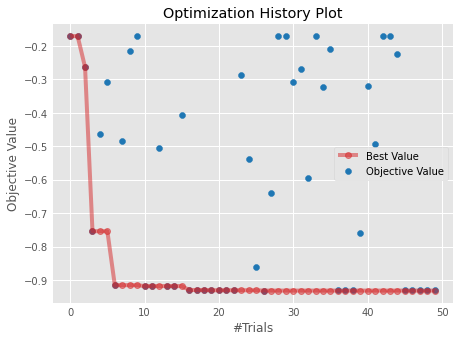

time: 302 ms (started: 2022-02-12 18:28:56 +00:00)


In [275]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig(export_dir +   '_plot_optimization_history.jpeg',bbox_inches='tight'  )

In [276]:
fig = optuna.visualization.plot_intermediate_values(study)
plt.savefig(export_dir +  '_plot_intermediate_values.jpeg' )

[W 2022-02-12 18:28:56,412] You need to set up the pruning feature to utilize `plot_intermediate_values()`


<Figure size 460.8x345.6 with 0 Axes>

time: 25.8 ms (started: 2022-02-12 18:28:56 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



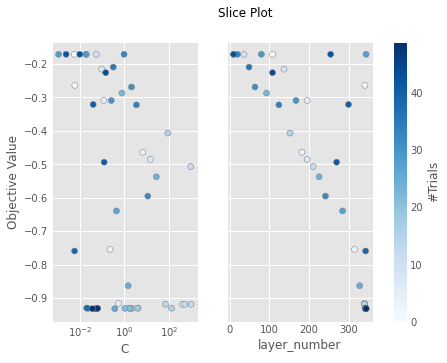

time: 629 ms (started: 2022-02-12 18:28:56 +00:00)


In [277]:
fig = optuna.visualization.matplotlib.plot_slice(study)
plt.savefig(export_dir +   '_plot_slice.jpeg',bbox_inches='tight' )

In [291]:
#Visualize parameter importances.
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig(export_dir  +  '_plot_param_importances.jpeg' ,bbox_inches='tight' )

KeyboardInterrupt: ignored

time: 3.19 s (started: 2022-02-12 18:39:06 +00:00)


In [ ]:
# optuna.visualization.plot_param_importances(study)

In [279]:
print('Best trial is number {}: score {},\nparams {}'.format(study.best_trial.number,study.best_trial.value,study.best_trial.params))

Best trial is number 26: score -0.9317500000000001,
params {'layer_number': 343, 'C': 0.3687374328017485}
time: 1.57 ms (started: 2022-02-12 18:31:16 +00:00)


In [280]:
study.best_trial.params

{'C': 0.3687374328017485, 'layer_number': 343}

time: 6.19 ms (started: 2022-02-12 18:31:30 +00:00)


# Evaluate best trials on test set 

In [281]:
# define DL model 
layer_number = int(study.best_trial.params['layer_number'])
# layer_number  = 2 
print('DL model layer output = {}'.format(model.layers[layer_number].name))
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_number].output)

DL model layer output = dropout_1
time: 21 ms (started: 2022-02-12 18:31:48 +00:00)


In [282]:
# predict features with neural net on WHOLE TRAIN and test
train_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_train, #/!\ vs df_train_
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
X_train_features = intermediate_layer_model.predict(train_generator)
#test 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
X_test_features = intermediate_layer_model.predict(test_generator)

Found 4000 validated image filenames belonging to 7 classes.
Found 1000 validated image filenames belonging to 7 classes.
time: 14.6 s (started: 2022-02-12 18:32:12 +00:00)


In [283]:
# define target on WHOLE TRAIN and test
y_train ,  y_test = df_train['label'] , df_test['label']

time: 1.41 ms (started: 2022-02-12 18:32:33 +00:00)


In [ ]:
# #get XGB param 
# XGB_best_param = {}
# for k,v in study.best_params.items():
#   if k != 'layer_number':
#     XGB_best_param[k] = v 
# # Get number of trees 
# bst_study_nb = study.best_trial.number
# n_estimators_early_stop = int(study.trials_dataframe().loc[bst_study_nb,'user_attrs_n_estimators'])
# n_estimators_early_stop

In [ ]:
# best_mod= XGBClassifier(**XGB_best_param,
#                          n_estimators = n_estimators_early_stop , # to set number of tree found using early stopping
#                         verbosity = 2,
#                         tree_method=tree_method,
#                         n_jobs=-1) 
# best_mod.get_params

In [284]:
study.best_params

{'C': 0.3687374328017485, 'layer_number': 343}

time: 3.31 ms (started: 2022-02-12 18:32:46 +00:00)


In [285]:
best_mod = SVC(C=0.3687374328017485)

time: 1.19 ms (started: 2022-02-12 18:33:06 +00:00)


In [286]:
# fit 
# best_mod.fit(X_train_features, y_train,verbose=True)
best_mod.fit(X_train_features, y_train)

SVC(C=0.3687374328017485)

time: 782 ms (started: 2022-02-12 18:33:09 +00:00)


In [287]:
# predict label with XGBoost 
test_pred_class = best_mod.predict(X_test_features).astype(int)

time: 360 ms (started: 2022-02-12 18:33:13 +00:00)


**************************************************TEST set classification report**************************************************
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       171
           1       0.79      0.83      0.81       169
           2       0.60      0.65      0.63       126
           3       0.58      0.63      0.60       139
           4       0.75      0.72      0.74       133
           5       0.63      0.62      0.63       147
           6       0.59      0.50      0.54       115

    accuracy                           0.67      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.67      0.67      0.67      1000



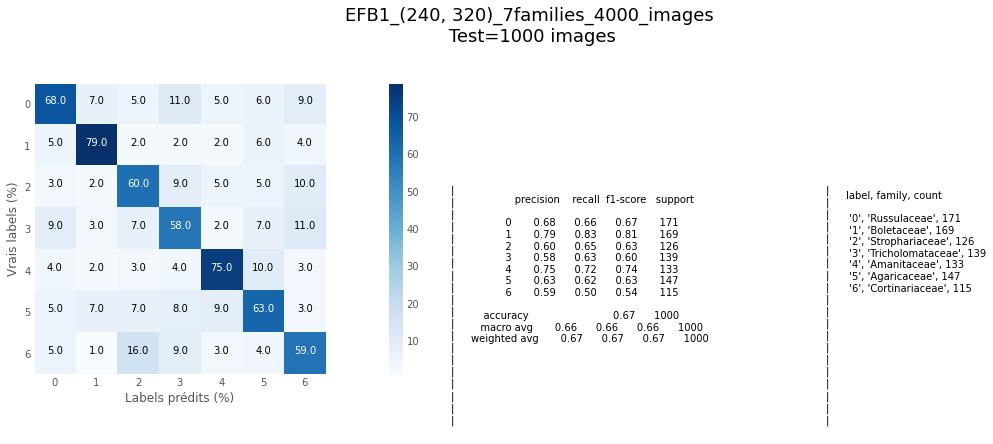

time: 847 ms (started: 2022-02-12 18:33:16 +00:00)


In [288]:
# true label
y_test_class= df_test['label'].values.astype(int)
print("*"*50 + 'TEST set classification report' + '*'*50)
# report 
print(metrics.classification_report(y_test_class, test_pred_class))
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + '_classification report.csv'
report.to_csv(report_path)
# conf matrix 
classes = df['gbif_info.family'].nunique()  # classes
# label and count for legend 
unique, counts = np.unique(y_test_class, return_counts=True)
test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
test_dict_label = dict_label_df.merge(test_dict_label,on='label')
test_dict_label = test_dict_label.drop(['size'], axis=1)
# plot 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir +  'Hybrid_model_conf_matrix.jpeg' ,bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2022-02-12 18:33:27,713] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


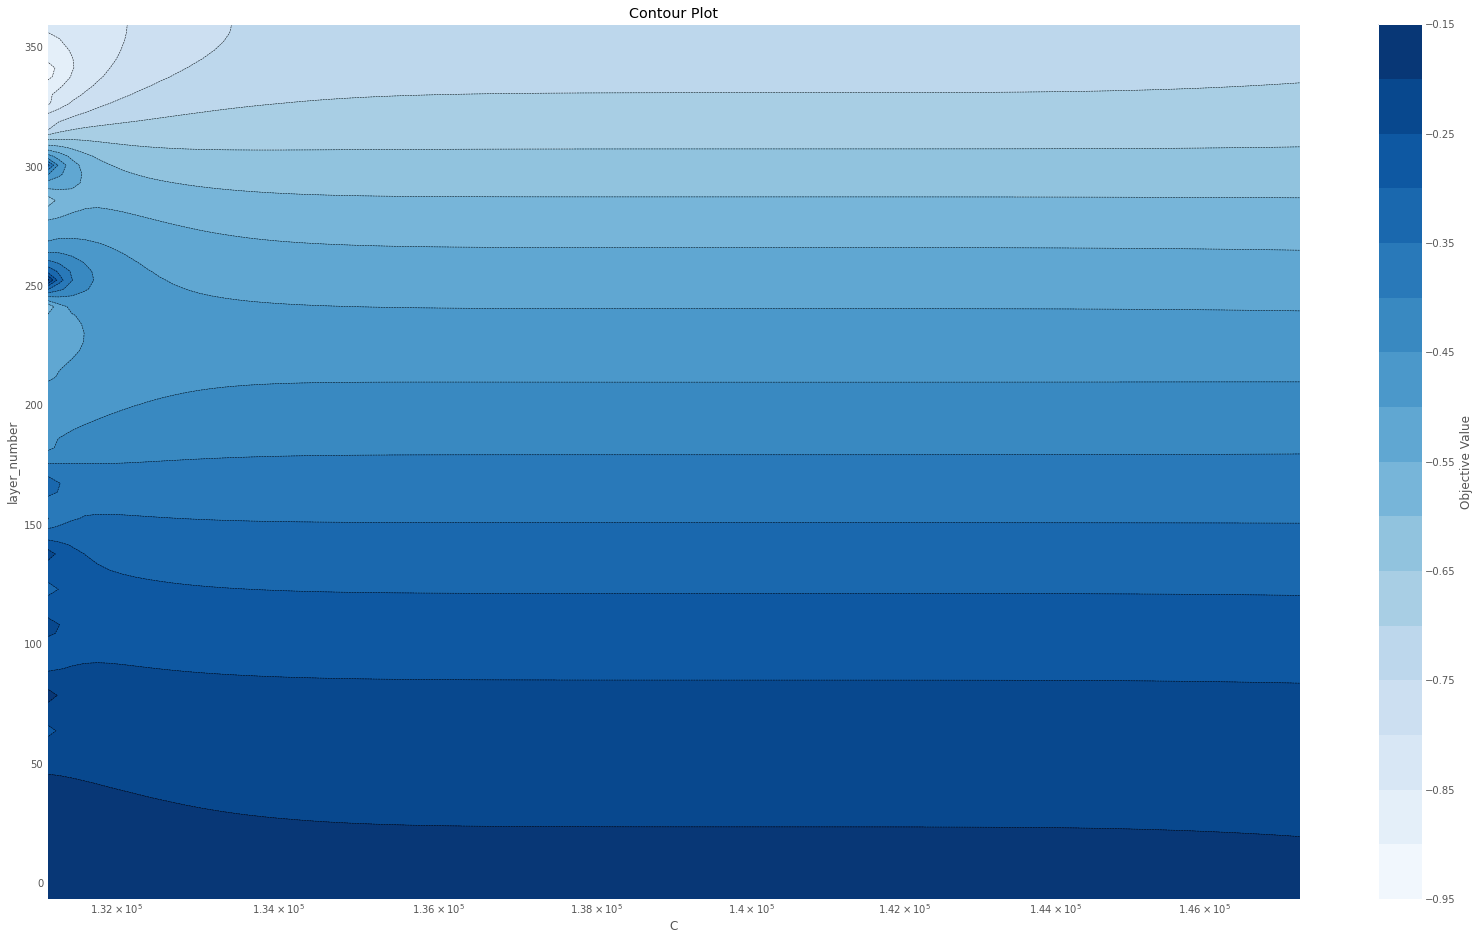

time: 4.62 s (started: 2022-02-12 18:33:27 +00:00)


In [289]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 25,15
optuna.visualization.matplotlib.plot_contour(study) #DEBUG,['num_units_0','lr']
plt.savefig(export_dir + pathinfos +  '_plot_contour.jpeg' ,bbox_inches='tight' )
rcParams['figure.figsize'] = 6.4, 4.8 #reset to default 